# Plot Land-Based Loadings

Builds a plot showing the loadings from rivers and point sources, using the NetCDF converted model input file.

In [1]:
ssm_pnt_nc = 'data/ssm_pnt_2014_v3.nc'
source_name = 'Ecology SSM v3 input file'
ssm_grid_file = '../SSM_Grid/Salish_Sea_Shelf_top_0.2_DZ_10_3_16.2dm'

# v3 boundary between rivers and point sources
rivers_slc = slice(159)
point_sources_slc = slice(159, None)
# T52 boundary
#rivers_slc = slice(94)
#point_sources_slc = slice(94, None)

# What loadings to examine
constituents_label = 'DIN'
constituents = ('no32','nh4')

river_labels = {
    8778: "Fraser",
    12754: "Skagit",
    15140: "Snohomish",
    13873: "Puyallup"
}
pntsrc_labels = {
    10186: "South King",
    9575: "West Point",
    13494: "Tacoma Central",
    7450: "Annacis",
    6775: "Iona",
    3241: "Clover Point"
}

import os.path as path

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.collections import PathCollection
from netCDF4 import Dataset
from shapely.geometry import Point
import contextily as cx
from adjustText import adjust_text

from fvcom.grid import FvcomGrid

Initialize some helper objects, the grid and the data file

In [2]:
grid = FvcomGrid.from_mesh(ssm_grid_file)
pnt_data = Dataset(ssm_pnt_nc)

Rivers are tricky because some of them have the discharges spread over two adjacent nodes. To handle this, check if the next node is adjacent the current one and, if so, assume it's part of the same river.

During the iteration, match up labels and coordinates. Rivers spread over multiple nodes get coordinates that are the mean location of the two nodes.

In [3]:
all_neis = grid.node_neis()
river_nodes = pnt_data['node'][rivers_slc]
merged_rivs = []
riv_coords = []
riv_labels = []
found_neighbors = set()
for i,(rn,next_rn) in enumerate(zip(river_nodes,river_nodes[1:].tolist() + [None])):
    if rn in found_neighbors:
        continue
    l = None
    if rn in river_labels.keys():
        l = river_labels[rn]
    if next_rn in all_neis[rn]:
        found_neighbors.add(next_rn)
        merged_rivs.append([i, i+1])
        riv_coords.append(Point(grid.ncoord[:2,[rn-1,next_rn-1]].mean(axis=1)))
        if next_rn in river_labels.keys():
            l = river_labels[next_rn]
    else:
        merged_rivs.append(i)
        riv_coords.append(Point(grid.ncoord[:2,rn-1]))
    riv_labels.append(l)
display(merged_rivs[:15])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, [14, 15]]

Helper function to assemble a loading GeoDataFrame

In [4]:
def build_loadings_gdf(indices, coords, labels):
    loadings = []
    for i in indices:
        total_conc = np.array([pnt_data[c][:,i] for c in constituents])
        # shape is (constituent, time, node) if more than one node
        # (constituent, time) if only one node
        total_conc = np.sum(total_conc, axis=0)
        # Now it's reduced to (time, node)
        l = (pnt_data['discharge'][:,i] * total_conc * 86.4)
        if l.ndim == 1:
            loadings.append(l.mean())
        else:
            # Sum over nodes then take the mean
            loadings.append(l.sum(axis=1).mean())
    gdf = gpd.GeoDataFrame({
        "geometry": coords,
        "loading": loadings,
        "label": labels
    }, crs='epsg:32610')
    return gdf

Build the GeoDataFrames for rivers and point sources. There's a bit of conversion work to do on the point sources that hasn't been taken care of yet, but it's much simpler than the rivers was above.

In [5]:
rivers = build_loadings_gdf(merged_rivs, riv_coords, riv_labels)

pntsrc_idxs = np.arange(pnt_data.dimensions['node'].size)[point_sources_slc]
pntsrc_nodes = pnt_data['node'][point_sources_slc]
pntsrc_coords = grid.nodes_gdf().loc[pntsrc_nodes, 'geometry']
ls = np.zeros(len(pntsrc_idxs), dtype=object)
ls[:] = None
for n,l in pntsrc_labels.items():
    ls[(pntsrc_nodes == n).nonzero()[0][0]] = l
pntsrcs = build_loadings_gdf(pntsrc_idxs, pntsrc_coords, ls)

Assemble the plot

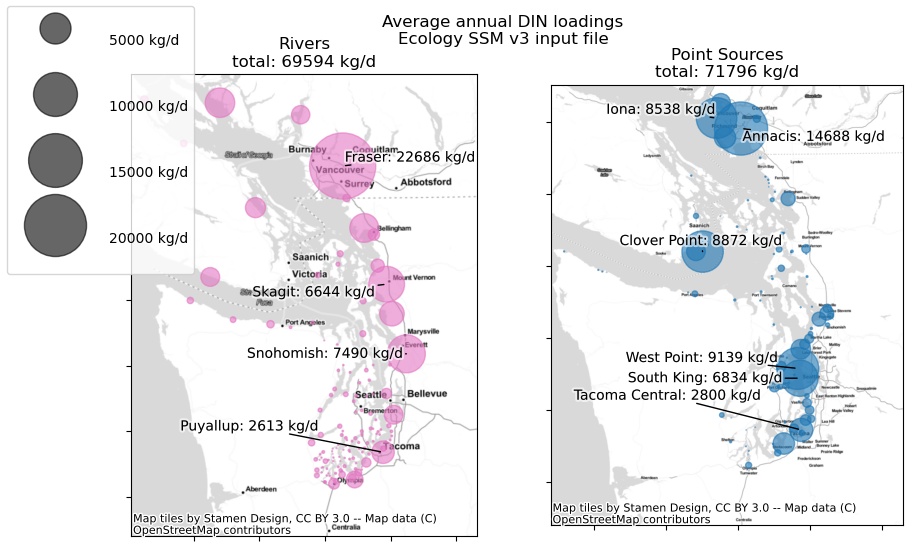

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))

def do_plot(ax, gdf, color, title):
    scatter = ax.scatter(gdf['geometry'].x, gdf['geometry'].y,
                         alpha=0.6, color=color, s=gdf['loading']/10)
    xmin, xmax, ymin, ymax = ax.axis()
    ax.set(title=f"{title}\ntotal: {gdf['loading'].sum():.0f} kg/d",
           xbound=(xmin, xmax + 0.2 * (xmax - xmin)),
           ybound=(5170000, None), xticklabels=(), yticklabels=()
          )
    texts = []
    for i,row in gdf.dropna(subset='label').iterrows():
        texts.append(
            ax.annotate(f"{row['label']}: {row['loading']:.0f} kg/d",
                        xy=(row['geometry'].x, row['geometry'].y),
                        ha='center', va='center', path_effects=[
                            pe.withStroke(linewidth=3, foreground='white',
                                          alpha=0.6)
                        ]))
    adjust_text(texts, gdf['geometry'].x.to_numpy(), gdf['geometry'].y.to_numpy(),
                force_points=(0.4, 1),
                ax=ax, arrowprops=dict(arrowstyle='-'))
    cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.Stamen.TonerLite)
    return scatter

rivers_coll = do_plot(axs[0], rivers, 'tab:pink', 'Rivers')
pntsrcs_coll = do_plot(axs[1], pntsrcs, 'tab:blue', 'Point Sources')
# See https://stackoverflow.com/a/76212772/413862
all_scatters = PathCollection(rivers_coll.get_paths() + pntsrcs_coll.get_paths(),
                              np.concatenate((rivers_coll.get_sizes(),
                                              pntsrcs_coll.get_sizes()))
                             )
handles, labels = all_scatters.legend_elements(prop="sizes", num=6, alpha=0.6,
                                               func=lambda s: s * 10,
                                               fmt='{x:.0f} kg/d')
legend_rows = np.sqrt(max(rivers['loading'].max(),
                              pntsrcs['loading'].max()) / 600)
fig.legend(handles, labels, loc='upper left',
           handlelength=legend_rows, handleheight=legend_rows
          )

fig.suptitle(f"Average annual {constituents_label} loadings\n{source_name}")

run_name = '.'.join(path.basename(ssm_pnt_nc).split('.')[:-1])
fig.savefig(f"notebook_outs/loadings_{run_name}_{constituents_label}.png")